In [1]:
# google drive
from google.colab import drive

# Data libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
from sklearn import datasets

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.api import qqplot
from mlxtend.plotting import plot_sequential_feature_selection as plt_sfs

# modeling librarires
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector

#
import requests
import cv2

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
plt.plot(X)

In [71]:
X = np.zeros((1000, 2))

t = np.arange(0, 100, .1)
X[:, 0] = np.sin(2*np.pi*t*.05)
X[:, 1] = np.sin(2*np.pi*t*.1)

y = 1 + 1*X[:, 0] + 1*X[:, 1]

In [3]:
boston_path = '/content/drive/MyDrive/IK/data/Boston.csv'
tv_path = '/content/drive/MyDrive/IK/data/tvmarketing.csv'

In [4]:
boston = pd.read_csv(boston_path)

feature_names = boston.drop(columns = ['MEDV']).columns.tolist()

In [5]:
def eig(X):
  eval, evec = np.linalg.eig(X)
  i_sort = np.argsort(eval)[::-1]
  eval, evec = eval[i_sort], evec[:, i_sort]
  return eval, evec

In [6]:
def svd(A,
        max_components = None, sval_cumpct_threshold = 1., keep_sig_sval = None,
        standardize = False, center = False,
        plot_sval_cumpct = False, figsize = None):

  # Center the data if desired
  if standardize:
    A = (A - A.mean(0))/A.std(0, ddof = 1)
  elif center:
    A = A - A.mean(0)

  # perform SVD
  U, S, V_H = np.linalg.svd(A)

  # Account for the fact that numpy transposes the right matrix inside
  V = V_H.conj().T

  # Get the percent cummulative sum of the singular values
  S_cumpct = S.cumsum()/S.sum()

  # Find the index of the first PC that meets the threshold
  if keep_sig_sval is not None:
    i_keep = np.where(np.sqrt(S) >= 1)[0]
  else:
    i_keep = np.arange(np.where(S_cumpct <= sval_cumpct_threshold)[0].max() + 1)

  # Number of components kept
  num_components = np.arange(1,len(S_cumpct)+1)

  # display results if desired
  if plot_sval_cumpct:
    plt.figure(figsize = figsize)
    plt.stem(num_components, S_cumpct*100, basefmt = ' ')
    plt.axhline(y = sval_cumpct_threshold*100, linestyle = '--', color = 'r', label = 'Threshold')
    plt.xticks(num_components)
    plt.yticks(np.arange(0, 101, 10))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumaltive Percent Explained [%]')
    plt.title(f"{np.round(S_cumpct[i_keep.max()]*100, 2)}% Explained by first {i_keep.max()} Components")
    plt.grid()

  if max_components is None:
    U = U[:, i_keep]
    S = S[i_keep]
    V = V[:, i_keep]
  else:
    U = U[:, :max_components]
    S = S[:max_components]
    V = V[:, :max_components]

  sign = np.sign([V[idx,col] for col,idx in enumerate(np.argmax(np.abs(V), axis = 0))])
  U, V = U*sign, V*sign

  A_proj = A.dot(V)

  return U, S, V, A_proj

In [7]:
# CRIM - per capita crime rate by town
# ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
# INDUS - proportion of non-retail business acres per town.
# CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
# NOX - nitric oxides concentration (parts per 10 million)
# RM - average number of rooms per dwelling
# AGE - proportion of owner-occupied units built prior to 1940
# DIS - weighted distances to five Boston employment centres
# RAD - index of accessibility to radial highways
# TAX - full-value property-tax rate per $10,000
# PTRATIO - pupil-teacher ratio by town
# LSTAT - % lower status of the population
# MEDV - Median value of owner-occupied homes in $1000's

Boxplot the data

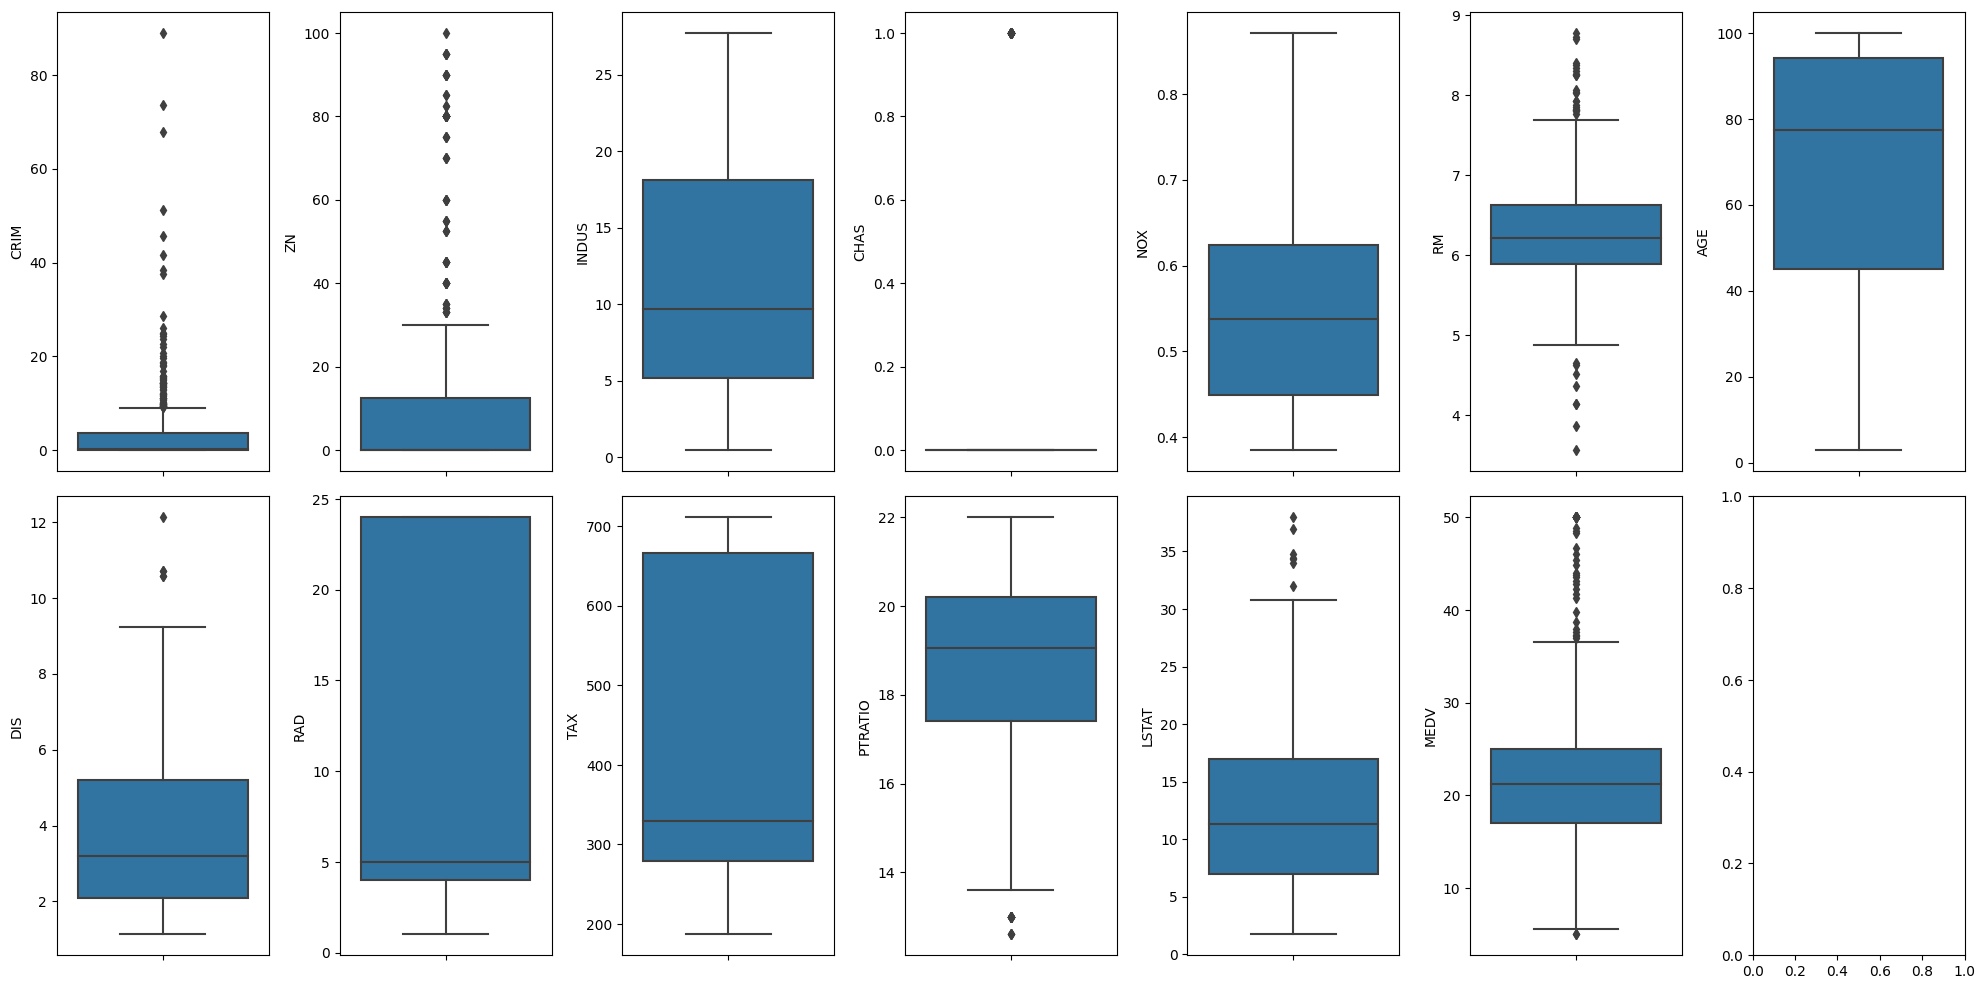

In [8]:
fig, ax = plt.subplots(2, 7, figsize = (20, 10))

axf = ax.flatten()
for i, (k,v) in enumerate(boston.items()):
  sns.boxplot(y = k, data = boston, ax = axf[i])

plt.tight_layout()

Covariance matrix

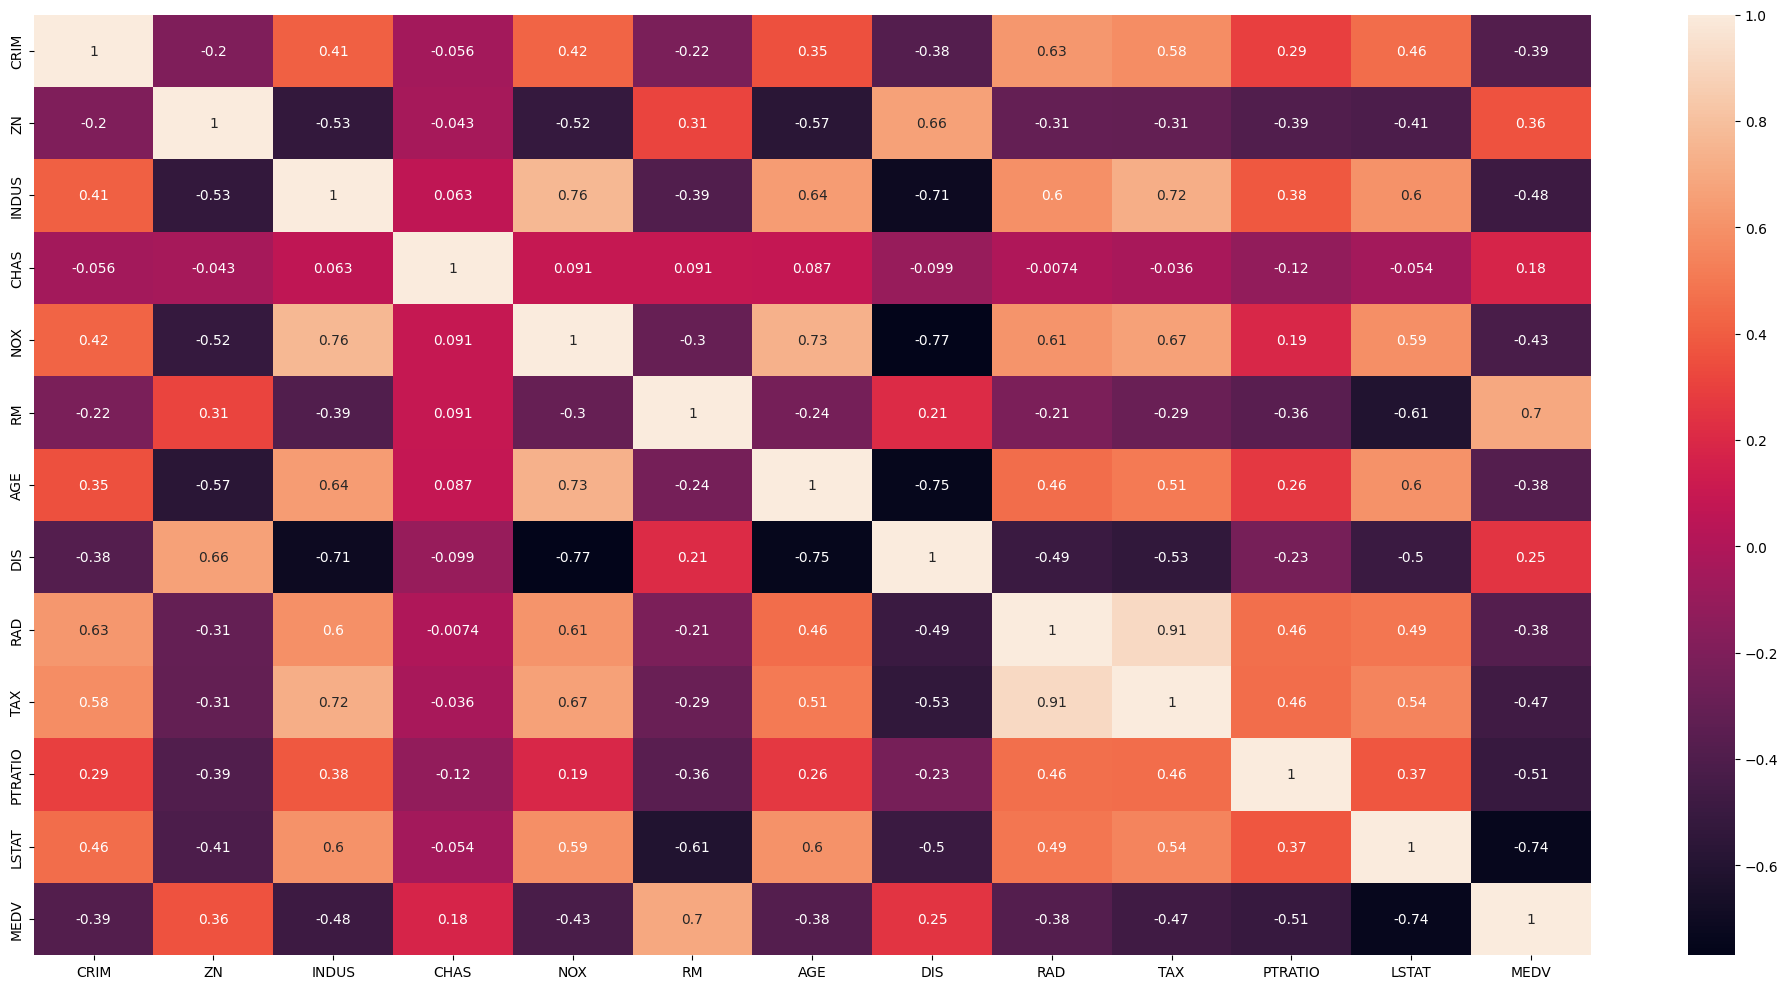

In [9]:
plt.figure(figsize = (20, 10))
sns.heatmap(boston.corr(), annot = True) ;
plt.tight_layout()

In [10]:
X, y = boston.drop(columns = ['MEDV']), boston['MEDV']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [12]:

U_train, S_train, V_train, X_proj_train = svd(X_train_s, figsize = None)

X_proj_test = X_test_s @ V_train

In [ ]:
num_components = V_train.shape[1]

fig, ax = plt.subplots(num_components, 1, figsize = (20, 5*num_components))

for i in range(num_components):

  pc_i = V_train[:, i]
  var_explained_i = (S_train[i]/S_train.sum()*100).round(2)

  ax[i].bar(feature_names, pc_i, color = ['r' if x >= 0 else 'b' for x in pc_i])
  ax[i].grid()
  ax[i].set_title(f"{var_explained_i}% Variance Explained", fontsize = 16)
  ax[i].set_ylabel(f"PC #{i+1}", fontsize = 16)
  ax[i].set_xticks(ticks = np.arange(len(feature_names)))
  ax[i].set_xticklabels(labels = feature_names, rotation = 90, fontsize = 12) ;

ax[-1].set_xlabel("Features", fontsize = 14)

plt.tight_layout()

In [ ]:
X_proj_train_1 = add_constant(X_proj_train)
X_proj_test_1 = add_constant(X_proj_test)

model = OLS(endog = y_train, exog = X_proj_train_1, hasconst = True)

results = model.fit()

y_pred_train = results.predict(X_proj_train_1)
y_pred_test = results.predict(X_proj_test_1)

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     78.44
Date:                Sat, 11 Nov 2023   Prob (F-statistic):           2.35e-90
Time:                        21:09:27   Log-Likelihood:                -1060.1
No. Observations:                 354   AIC:                             2146.
Df Residuals:                     341   BIC:                             2197.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.0158      0.262     87.910      0.000      22.501      23.531
x1            -2.3060      0.109    -21.252      0.000      -2.519      -2.093
x2             3.3571      0.218     15.400      0.000       2.928       3.786
x3             2.8807      0.236     12.200      0.000       2.416       3.345
x4            -0.6307      0.284     -2.223      0.027      -1.189      -0.073
x5             2.0420      0.294      6.957      0.000       1.465       2.619
x6            -0.7238      0.360     -2.011      0.045      -1.432      -0.016
x7            -1.5195      0.418     -3.637      0.000      -2.341      -0.698
x8             0.4863      0.490      0.992      0.322      -0.478       1.450
x9            -1.1917      0.543     -2.195      0.029      -2.259      -0.124
x10           -1.3193      0.593     -2.224      0.027      -2.486      -0.152
x11           -2.5790      0.653     -3.952      0.000      -3.863      -1.295
x12           -2.6819      1.035     -2.590      0.010      -4.719      -0.645
==============================================================================
Omnibus:                      111.779   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              412.185
Skew:                           1.356   Prob(JB):                     3.13e-90
Kurtosis:                       7.538   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

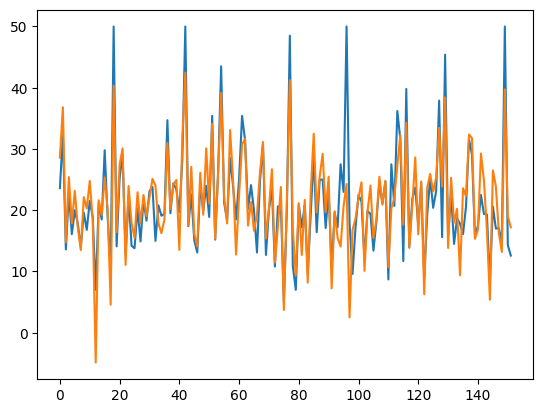

In [ ]:
plt.plot(y_test.values)
plt.plot(y_pred_test)

Data from sklearn

In [ ]:
dataset = datasets.load_diabetes()

# Access the features (data) and target (labels) from the dataset
X = dataset.data
y = dataset.target

feature_names = dataset.feature_names
# target_names = dataset.target_names

# Check the shape of the data and target arrays
print("Shape of X (data):", X.shape)
print("Shape of y (target):", y.shape)

# Check the feature names and target names
print("Feature names:", feature_names)
# print("Target names:", target_names)


Shape of X (data): (442, 10)
Shape of y (target): (442,)
Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


In [ ]:
df = pd.DataFrame(dataset['data'], columns = dataset.feature_names)
df['target'] = y

In [ ]:
df.head(10)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041176,-0.096346,97.0
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062917,-0.038357,138.0
7,0.063504,0.050680,-0.001895,0.066629,0.090620,0.108914,0.022869,0.017703,-0.035816,0.003064,63.0
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014960,0.011349,110.0
9,-0.070900,-0.044642,0.039062,-0.033213,-0.012577,-0.034508,-0.024993,-0.002592,0.067737,-0.013504,310.0


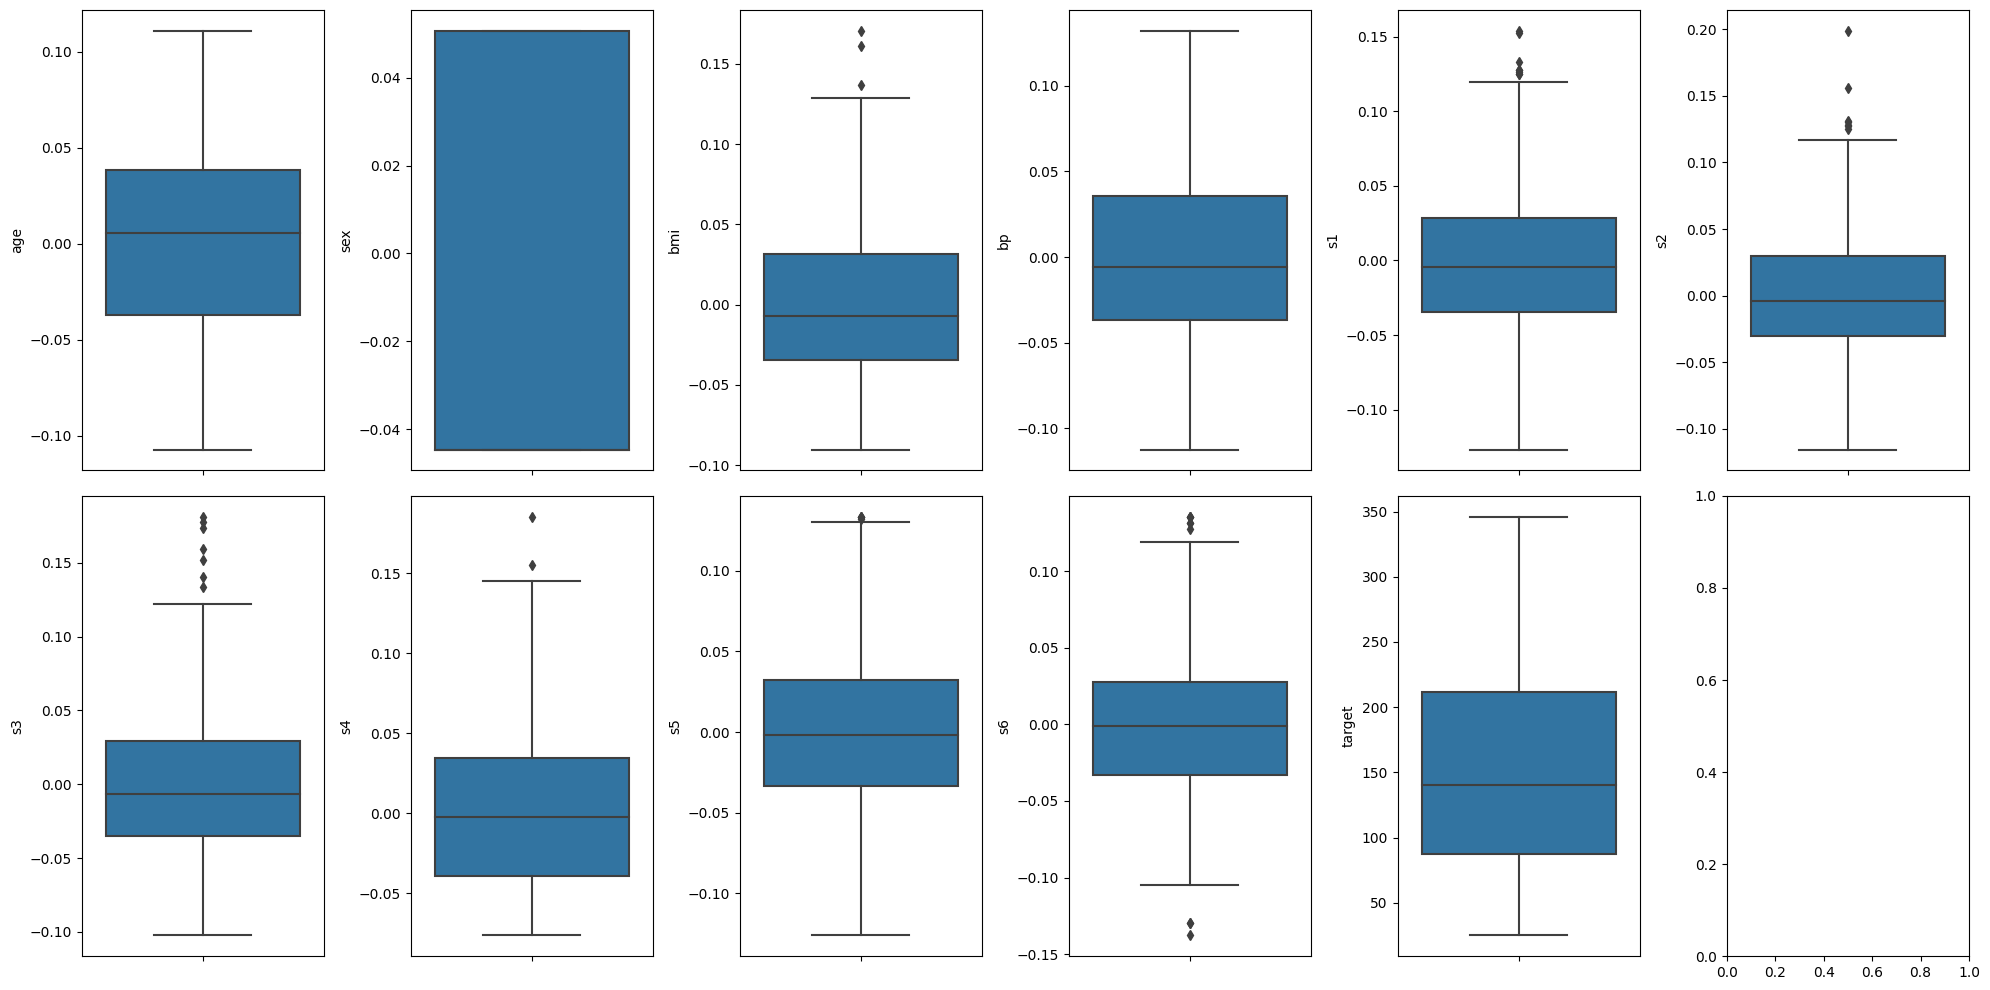

In [ ]:
fig, ax = plt.subplots(2, 6, figsize = (20, 10))

axf = ax.flatten()
for i, (k,v) in enumerate(df.items()):
  sns.boxplot(y = k, data = df, ax = axf[i])

plt.tight_layout()

Covariance matrix

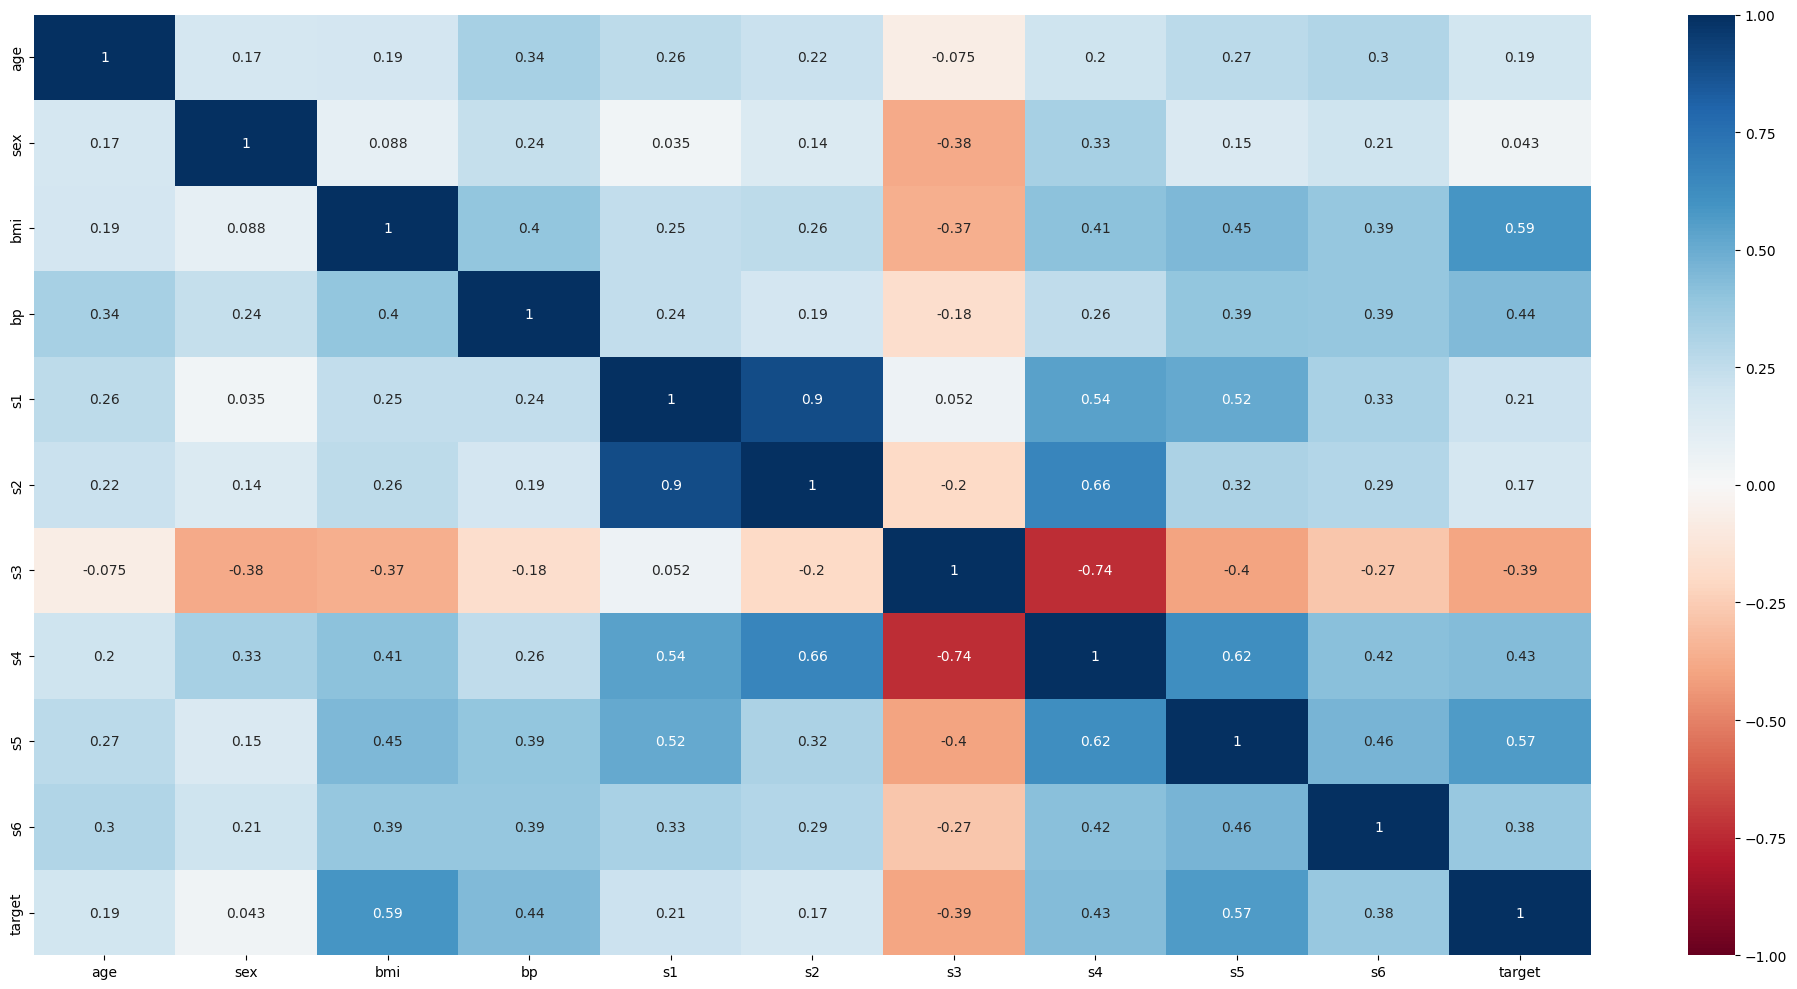

In [ ]:
plt.figure(figsize = (20, 10))
sns.heatmap(df.corr(), cmap = 'RdBu', annot = True, vmin = -1, vmax = 1) ;
plt.tight_layout()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [ ]:

U_train, S_train, V_train, X_proj_train = svd(X_train_s, figsize = None)

X_proj_test = X_test_s @ V_train

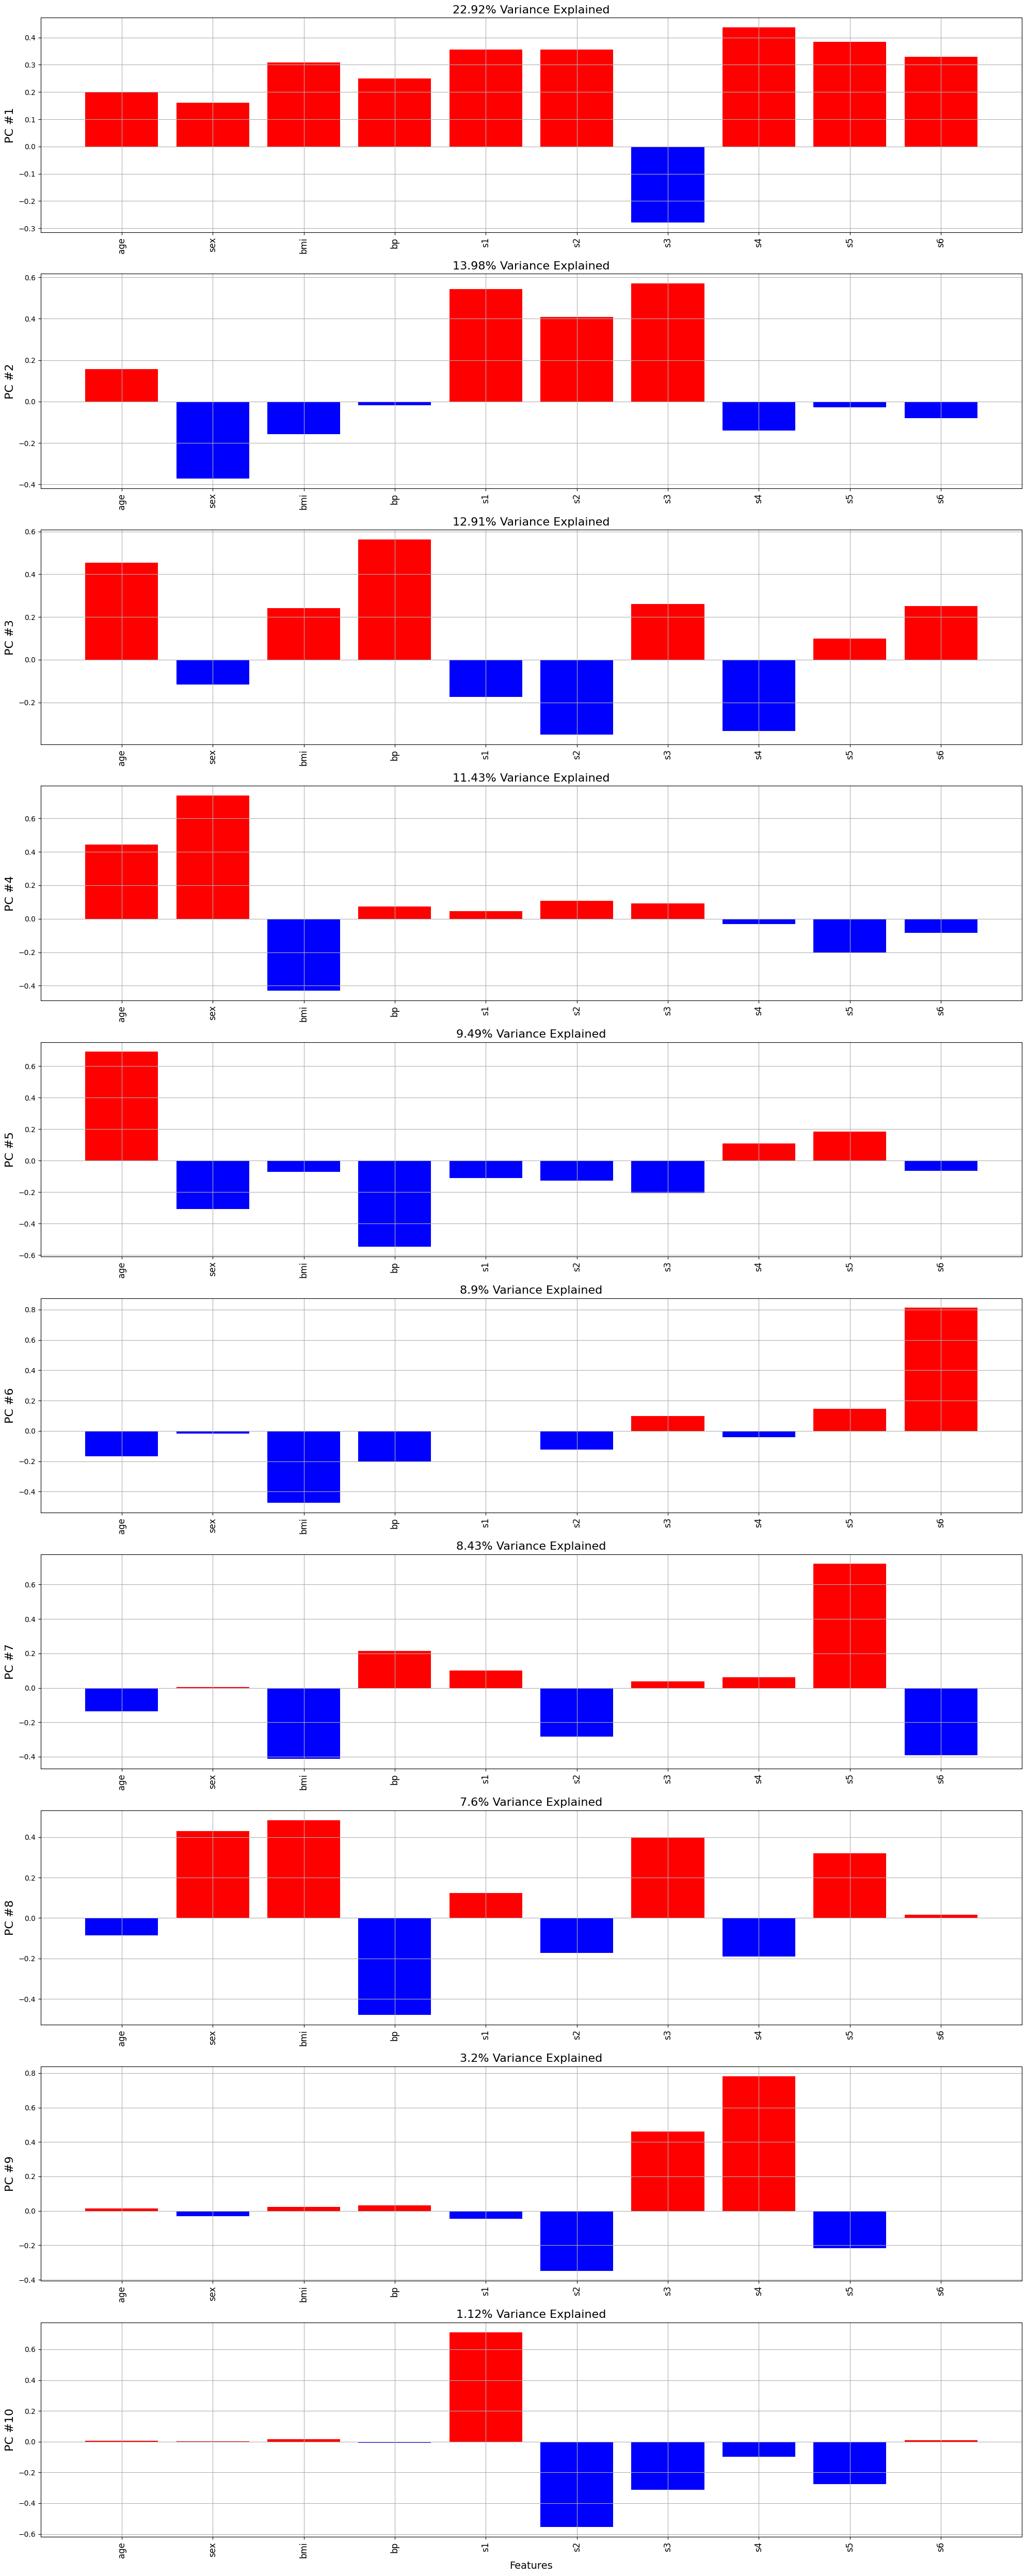

In [ ]:
num_components = V_train.shape[1]

fig, ax = plt.subplots(num_components, 1, figsize = (20, 5*num_components))

for i in range(num_components):

  pc_i = V_train[:, i]
  var_explained_i = (S_train[i]/S_train.sum()*100).round(2)

  ax[i].bar(feature_names, pc_i, color = ['r' if x >= 0 else 'b' for x in pc_i])
  ax[i].grid()
  ax[i].set_title(f"{var_explained_i}% Variance Explained", fontsize = 16)
  ax[i].set_ylabel(f"PC #{i+1}", fontsize = 16)
  ax[i].set_xticks(ticks = np.arange(len(feature_names)))
  ax[i].set_xticklabels(labels = feature_names, rotation = 90, fontsize = 12) ;

ax[-1].set_xlabel("Features", fontsize = 14)

plt.tight_layout()

In [ ]:
X_proj_train_1 = add_constant(X_proj_train)
X_proj_test_1 = add_constant(X_proj_test)

model = OLS(endog = y_train, exog = X_proj_train_1, hasconst = True)

results = model.fit()

y_pred_train = results.predict(X_proj_train_1)
y_pred_test = results.predict(X_proj_test_1)

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     32.86
Date:                Sat, 11 Nov 2023   Prob (F-statistic):           1.37e-42
Time:                        22:02:47   Log-Likelihood:                -1671.5
No. Observations:                 309   AIC:                             3365.
Df Residuals:                     298   BIC:                             3406.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        153.9029      3.132     49.132      0.000     147.738     160.067
x1            21.5241      1.575     13.668      0.000      18.425      24.623
x2           -12.9219      2.583     -5.003      0.000     -18.004      -7.839
x3            18.3495      2.796      6.564      0.000      12.848      23.851
x4           -24.2960      3.158     -7.693      0.000     -30.511     -18.081
x5             0.3943      3.803      0.104      0.917      -7.089       7.878
x6           -12.9072      4.055     -3.183      0.002     -20.886      -4.928
x7             4.6814      4.282      1.093      0.275      -3.745      13.108
x8            -1.3547      4.747     -0.285      0.776     -10.696       7.987
x9             1.7871     11.278      0.158      0.874     -20.408      23.982
x10          -55.9292     32.191     -1.737      0.083    -119.279       7.421
==============================================================================
Omnibus:                        1.511   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.470   Jarque-Bera (JB):                1.417
Skew:                           0.056   Prob(JB):                        0.492
Kurtosis:                       2.688   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

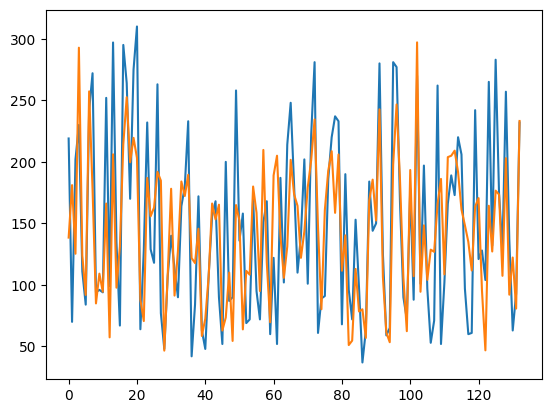

In [ ]:
plt.plot(y_test)
plt.plot(y_pred_test)